<a href="https://www.kaggle.com/code/mahnoormchaudhry/knes381-python-final?scriptVersionId=231642634" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/knes381vo2/subject_1321.xlsx
/kaggle/input/knes381vo2/subject_1432.xlsx
/kaggle/input/knes381vo2/subject_1321.csv
/kaggle/input/knes381vo2/subject_1232.csv
/kaggle/input/knes381vo2/VO2_CSV.csv
/kaggle/input/knes381vo2/subject_1232.xlsx
/kaggle/input/knes381vo2/subject_1432.csv
/kaggle/input/knes381vo2/subject_1523.csv
/kaggle/input/knes381vo2/VO2_excel.xlsx
/kaggle/input/knes381vo2/subject_1523.xlsx


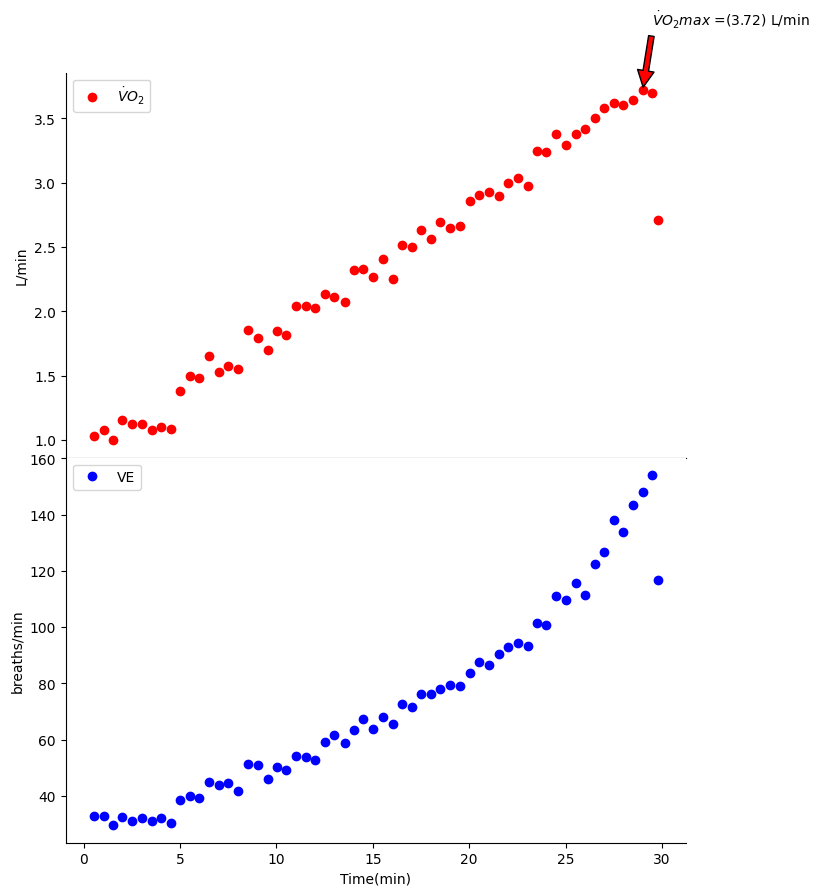

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Lets read in our file now
df = pd.read_csv('../input/knes381vo2/subject_1432.csv', header=[0], skiprows=[1,2,3])

# please note that while this is an output file from the parvo-metabolics cart we have
# I have edited this data set and simplied the header file on it

# rename our column headers
df = df.rename(columns={'VE/': 'VE/VO2','VE/.1': 'VE/VCO2'})

# simplify our terms to reduce future typing... 
# it is easier to write plot x, y than plot df['Time'], df['VO2']
x = df['TIME']
y = df['VO2']
y1 = df['VE']

# Gas Exchange Threshold (GET) estimation using V-Slope method
# GET occurs when VCO2 vs VO2 slope significantly increases
slope_changes = np.gradient(np.gradient(y))  # Second derivative to find inflection point
GET_index = np.argmax(slope_changes)  # First steepest slope change
GET_vo2 = x.iloc[GET_index]  # VO2 value at GET


#Find VO2 max value 
ymax = max(y)

# find the x position of the ymax value or where ymax occurs on the x axis
xmax = x[y.argmax()]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 10)) # Note I increased the figure size here.

# this line seperates the two plots...
fig.subplots_adjust(hspace=0)

# annotate the position of V02 max before plotting the value, we could do this later but why.

ax[0].annotate('$\dot VO_2max$ =({}) L/min'.format(round(ymax, 2)), 
               xy=(xmax, ymax), xytext=(xmax+.5, ymax+ .5),
               arrowprops=dict(facecolor='red', shrink= 0.05),
                )

ax[0].plot(x, y, 'o', label=('$\dot VO_2$'), c='r' )
# in the line of code below I hide the top and right black bars serrounding the plot for APA format.
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].set(ylabel=('L/min'))
ax[0].legend()
#note all these set features could be added in one line but reading it would be difficult

# Second plot of values down from the top
ax[1].plot(x, y1, 'o', label=('VE'), c='b')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].set(ylabel=('breaths/min'))
ax[1].set(xlabel=('Time(min)'))
ax[1].legend()

# save the figure before we show it... or it will be blank
fig.savefig("VO2-VE-4.png", dpi=300, bbox_inches = "tight")
fig.show()

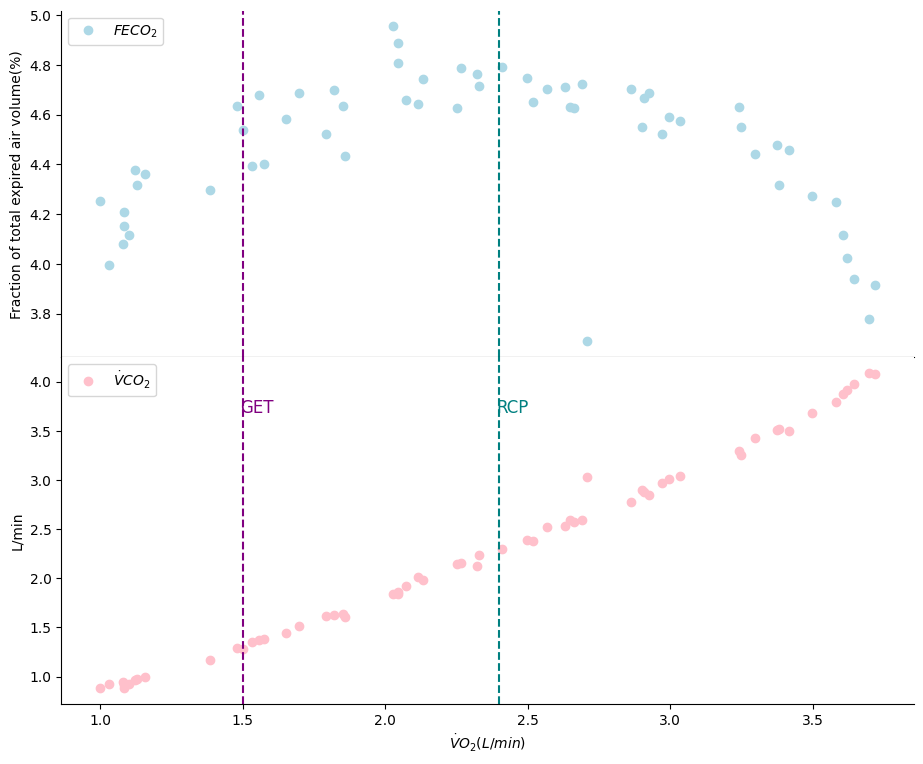

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

df = pd.read_csv('../input/knes381vo2/subject_1432.csv', header=[0], skiprows=[1,2,3])

df = df.rename(columns={'VE/': 'VE/VO2','VE/.1': 'VE/VCO2'})

#Define
x = df['VO2']
y = df['FECO2']
y1 = df['VCO2']

#Find VO2 max value 
ymax = max(y)

# find the x position of the ymax value or where ymax occurs on the x axis
xmax = x[y.argmax()]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(11, 9))

# this line seperates the two plots...
fig.subplots_adjust(hspace=0)

ax[0].plot(x, y, 'o', label=('$FECO_2$'), c='lightblue' )
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].set(ylabel=('Fraction of total expired air volume(%)'))
ax[0].legend(loc='upper left')

# Second plot of values down from the top
ax[1].plot(x, y1, 'o', label=('$\dot VCO_2$'), c='pink')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].set(ylabel=('L/min'))
ax[1].set(xlabel=('$\dot VO_2(L/min)$'))
ax[1].legend()

# Add ventilatory thresholds (T1 and T2)
T1_vo2_value = 1.49957454204559 # Value for T1 VO2
T2_vo2_value = 2.39717984199524  # Value for T2 VO2

# Draw lines representing the thresholds on both subplots
ax[0].axvline(x=T1_vo2_value, color='purple', linestyle='--', label='T1')
ax[0].axvline(x=T2_vo2_value, color= 'teal', linestyle='--', label='T2')
ax[1].axvline(x=T1_vo2_value, color='purple', linestyle='--', label='T1')
ax[1].axvline(x=T2_vo2_value, color='teal', linestyle='--', label='T2')

# Add text for T1 and T2 lines
ax[1].text(T1_vo2_value + 0.05, max(y1) * 0.9, 'GET', color='purple', fontsize=12, ha='center')
ax[1].text(T2_vo2_value + 0.05, max(y1) * 0.9, 'RCP', color='teal', fontsize=12, ha='center')


# save the figure before we show it... or it will be blank
fig.savefig("FECO2-VCO2-VO2.png", dpi=300, bbox_inches = "tight")
fig.show()